In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from data_loader import load_data

In [16]:
def predict_test(model, model_name):
    test_x = load_data("data_processed/task1_test_data.csv", is_train=False)
    test_y_pred = model.predict(test_x)
    test_sub = pd.DataFrame({
        'id': range(len(test_y_pred)),  # ID from 0 to len(predictions) - 1
        'home_team_win': test_y_pred
    })
    test_sub.to_csv(f"submission/{model_name}_1.csv", index=False)

    test_x = load_data("data_processed/task2_test_data.csv", is_train=False)
    test_y_pred = model.predict(test_x)
    test_sub = pd.DataFrame({
        'id': range(len(test_y_pred)),  # ID from 0 to len(predictions) - 1
        'home_team_win': test_y_pred
    })
    test_sub.to_csv(f"submission/{model_name}_2.csv", index=False)

## Logistic

In [ ]:
data_x, data_y = load_data("data_processed/train_data.csv")
print('feature len:', len([_ for _ in data_x.columns.tolist() ]))

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
model = LogisticRegression(penalty='l2', max_iter=5000)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(data_x, data_y)
model = grid_search.best_estimator_
mean_valid = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

print("best param: ", grid_search.best_params_)
print(f'cv validation accuracy: {mean_valid:.4f}')

# fit the whole data
model.fit(data_x, data_y)


feature len: 156
best param:  {'C': 0.001}
cv validation accuracy: 0.5597


LogisticRegression(C=0.001, max_iter=5000)

## Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
data_x, data_y = load_data("data_processed/train_data.csv")
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.2)

# Train the Bagging Ensemble on the entire dataset
bagging_model = BaggingClassifier(
    estimator=LogisticRegression(
        penalty='l2',
        C=0.001,
        max_iter=5000,
    ),
    n_estimators=20,
    max_samples=0.8,
    max_features=0.7,
    bootstrap=True,
    n_jobs=-1,
)
bagging_model.fit(train_x, train_y)

valid_y_pred = bagging_model.predict(valid_x)
accuracy_score(valid_y, valid_y_pred)


0.55420054200542

In [62]:
bagging_model.fit(data_x, data_y)
predict_test(bagging_model, "bagging_linear")

Hyper-param search

In [19]:
param_grid = {
    'n_estimators': [10, 20, 50],         
    'max_samples': [0.6, 0.8],            
    'max_features': [0.5, 0.8, 1.0],                
    'estimator__C': [0.001, 0.01, 0.1, 1, 10], 
}

bagging_model = BaggingClassifier(
    estimator=LogisticRegression(
        penalty='l2',
        C=0.001,
        max_iter=5000,
    )
)
grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    cv=5,                
    scoring='accuracy',  
)
grid_search.fit(data_x, data_y)

best_score = grid_search.best_score_
mean_valid = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

print("best param: ", grid_search.best_params_)
print(f'mean cv validation accuracy: {mean_valid:.4f}')
print(f'best cv accuracy: {best_score:.4f}')

best param:  {'estimator__C': 0.001, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 20}
mean cv validation accuracy: 0.5657
best cv accuracy: 0.5657


## Neural Network

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# dummy_col = ["home_team_abbr", "away_team_abbr", "season"]
dummy_col = None
data_x, data_y = load_data("data_processed/train_data.csv", dummy_col)
print('Feature length:', len([_ for _ in data_x.columns.tolist()]))

pd.set_option('display.max_rows', None)
# print(data_x.dtypes)

def standardize(df, col):
    scaler = StandardScaler()
    df[[col]] = scaler.fit_transform(df[[col]])

float_cols = data_x.select_dtypes(include=['float']).columns.tolist()
[standardize(data_x, _) for _ in float_cols]

train_x, valid_x, train_y, valid_y = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42
)

train_x = torch.tensor(train_x.values, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
valid_x = torch.tensor(valid_x.values, dtype=torch.float32)
valid_y = torch.tensor(valid_y, dtype=torch.long)


valid_x.dtype

Feature length: 156


torch.float32

In [ ]:

# def normalize(df, col):
#     df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())




# def process(df):
#     standardize(df, 'home_team_rest')
#     standardize(df, 'away_team_rest')
#     standardize(df, 'home_pitcher_rest')
#     standardize(df, 'away_pitcher_rest')


# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# process(data_x)
# data_x.max()


# train_x, valid_x, train_y, valid_y = train_test_split(
#     data_x, data_y, test_size=0.2, random_state=42
# )

# train_x = torch.tensor(train_x.values)
# train_y = torch.tensor(train_y, dtype=torch.long)
# valid_x = torch.tensor(valid_x.values)
# valid_y = torch.tensor(valid_y, dtype=torch.long)

# process(train_x)
# TODO: need to normalized some of the value (rest)


# df = train_x
# row = train_x.iloc[0]
# train_x.describe()
# vertical_table = row.to_frame(name="Value")
# vertical_table
# train_x.shape
# plt.hist(train_x.flatten(), bins=100);

In [83]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

param_grid = {
    'hidden_dim': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
}

fixed_epochs = 20
best_accuracy = 0
best_params = None

for params in tqdm(ParameterGrid(param_grid), desc="Tuning parameters"):
    # Create the model
    model = MLP(input_dim=train_x.shape[1], hidden_dim=params['hidden_dim'], output_dim=len(torch.unique(train_y)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])

    # Training loop
    for epoch in range(fixed_epochs):
        model.train()
        for i in range(0, len(train_x), params['batch_size']):
            batch_x = train_x[i:i + params['batch_size']]
            batch_y = train_y[i:i + params['batch_size']]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_x)
        valid_preds = torch.argmax(valid_outputs, dim=1).numpy()
        accuracy = accuracy_score(valid_y, valid_preds)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Tuning parameters: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]

Best parameters: {'batch_size': 64, 'hidden_dim': 64, 'learning_rate': 0.01}
Best validation accuracy: 0.5795


Epoch [1/10], Train Loss: 274259345.7116, Valid Accuracy: 0.5285
Epoch [2/10], Train Loss: 275727330.7362, Valid Accuracy: 0.5000
Epoch [3/10], Train Loss: 287539439.5464, Valid Accuracy: 0.5086
Epoch [4/10], Train Loss: 170887705.0130, Valid Accuracy: 0.5059
Epoch [5/10], Train Loss: 49294299.8577, Valid Accuracy: 0.5352
Epoch [6/10], Train Loss: 20338363.9580, Valid Accuracy: 0.5136
Epoch [7/10], Train Loss: 7264547.2476, Valid Accuracy: 0.4621
Epoch [8/10], Train Loss: 2401486.2151, Valid Accuracy: 0.4589
Epoch [9/10], Train Loss: 752261.3082, Valid Accuracy: 0.4634
Epoch [10/10], Train Loss: 676832.2418, Valid Accuracy: 0.5452


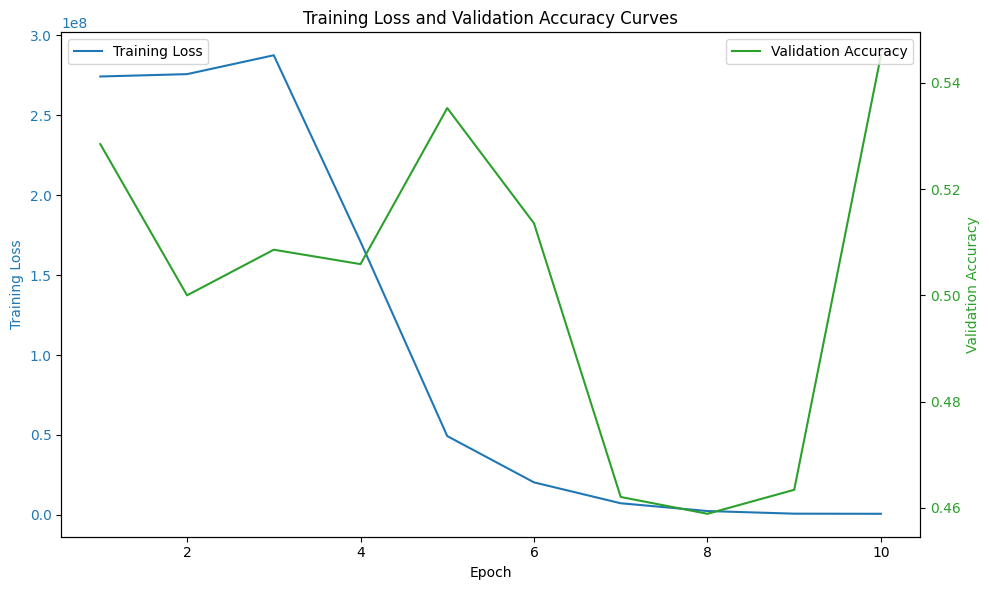

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming MLP is defined elsewhere
# from your_model_definition import MLP
fixed_epochs = 10
best_params = {
    "batch_size": 64,
    "hidden_dim": 64,
    "learning_rate": 1e4,
}

# Train final model with best params and plot loss/validation accuracy curves
model = MLP(input_dim=train_x.shape[1], 
            hidden_dim=best_params['hidden_dim'], 
            output_dim=len(torch.unique(train_y)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

train_losses = []
valid_accuracies = []

for epoch in range(fixed_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(train_x), best_params['batch_size']):
        batch_x = train_x[i:i + best_params['batch_size']]
        batch_y = train_y[i:i + best_params['batch_size']]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    average_train_loss = epoch_loss / len(train_x)
    train_losses.append(average_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_x)
        _, predicted = torch.max(valid_outputs, 1)
        correct = (predicted == valid_y).sum().item()
        accuracy = correct / len(valid_y)
        valid_accuracies.append(accuracy)
    
    # (Optional) Print progress
    print(f"Epoch [{epoch+1}/{fixed_epochs}], "
          f"Train Loss: {average_train_loss:.4f}, "
          f"Valid Accuracy: {accuracy:.4f}")

# Plotting Training Loss and Validation Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(range(1, fixed_epochs + 1), train_losses, label="Training Loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Validation Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, fixed_epochs + 1), valid_accuracies, label="Validation Accuracy", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title("Training Loss and Validation Accuracy Curves")
fig.tight_layout()  # Otherwise the right y-label is slightly clipped
plt.show()